# Network Analysis on Neuro-Imaging Data and Classification using various Machine Learning Models


# Installation and Import of required Libraries

In [1]:
!pip install nilearn nibabel matplotlib scikit-learn
!pip install torch_geometric
!pip install xgboost
from IPython.display import clear_output
clear_output(wait=True)
print("")

In [2]:
import os
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from tqdm import tqdm
from google.colab import drive
from nilearn import datasets, plotting, connectome
from nilearn.input_data import NiftiLabelsMasker
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.utils.data import TensorDataset

# Download and Labelling of Dataset (1 is ASD, 2 is Control)

In [3]:
# Fetch data
# abide_control = datasets.fetch_abide_pcp(n_subjects=None, derivatives=['func_preproc'], pipeline='cpac')
abide_asd = datasets.fetch_abide_pcp(n_subjects=200, derivatives=['func_preproc'], pipeline='cpac', DX_GROUP=1)
abide_control = datasets.fetch_abide_pcp(n_subjects=200, derivatives=['func_preproc'], pipeline='cpac', DX_GROUP=2)

# Combine into one dictionary
abide_data = {}
abide_data['func_preproc'] = abide_asd['func_preproc'] + abide_control['func_preproc']
if 'confounds' in abide_asd and 'confounds' in abide_control:
  abide_data['confounds'] = abide_asd['confounds'] + abide_control['confounds']
abide_data['phenotypic'] = {}
phenotypic_fields = abide_asd['phenotypic'].dtype.names
for field in phenotypic_fields:
    abide_data['phenotypic'][field] = np.concatenate([abide_asd['phenotypic'][field],
                                                      abide_control['phenotypic'][field]])
# Check
clear_output(wait=True)
print(f"Number of functional MRI files: {len(abide_data['func_preproc'])}")
labels = abide_data['phenotypic']['DX_GROUP']
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"Label distribution: {dict(zip(unique_labels, counts))}")

Number of functional MRI files: 400
Label distribution: {1: 200, 2: 200}


# Preprocessing and Visualization of 1 subject of each Group



In [4]:
# Fetch Harvard Oxford atlas and define masker for time series
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)
connectivity_measure = connectome.ConnectivityMeasure(kind='correlation')
# Match label length to no. of ROIs, filter out unused
valid_labels = [label for label in atlas.labels if label != "Background"]


Dataset created in /root/nilearn_data/fsl



Downloaded 25673728 of 25716861 bytes (99.8%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/fsl/7311eb6e2a75d5a4596a018fd2af9a77/HarvardOxford.tgz..... done.


Control

Time series shape: (196, 48)
Number of labels: 49


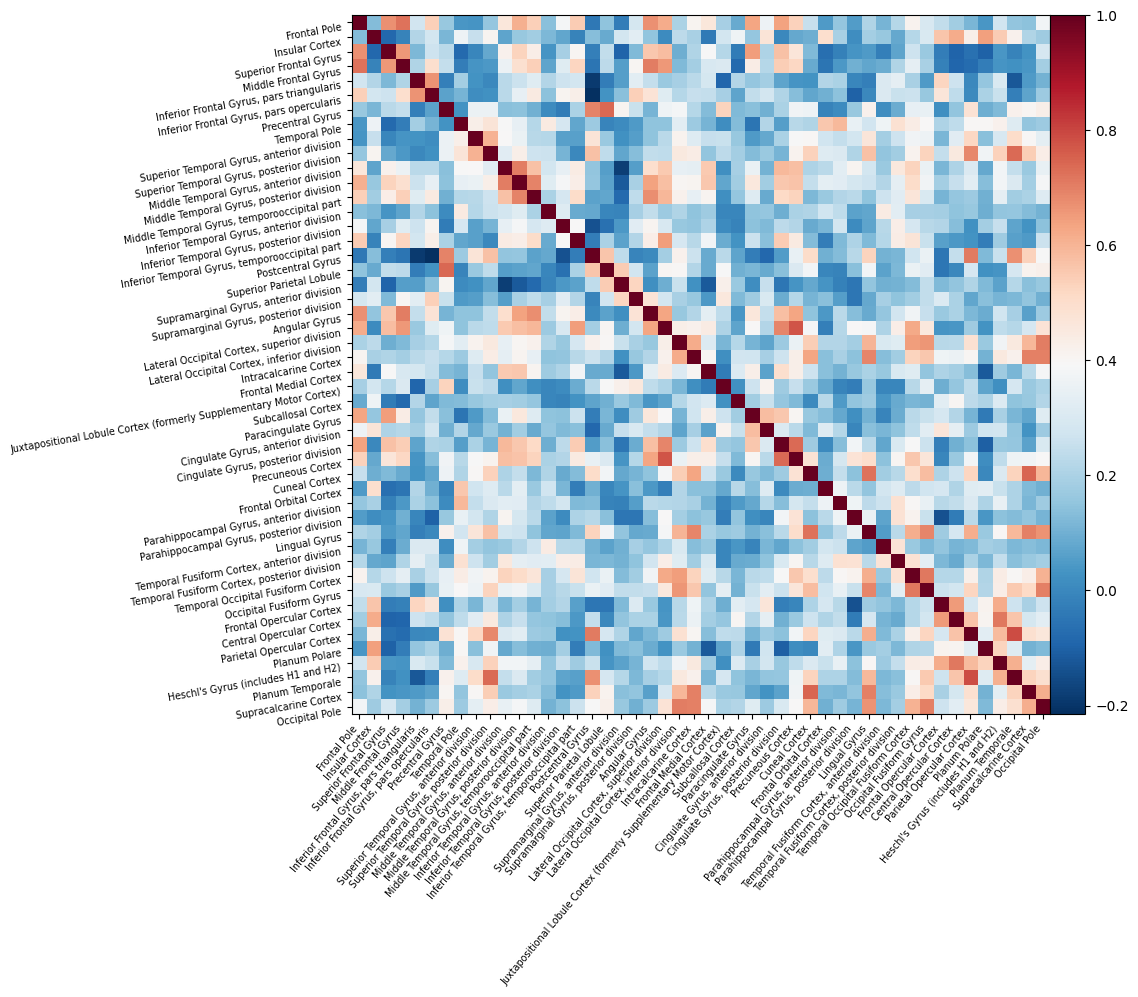

In [5]:
def visualize_one(abide_data):
    # Get names and confounds
    fmri_filename = abide_data['func_preproc'][0]
    confounds_filename = abide_data['confounds'][0] if 'confounds' in abide_data else None

    # Extract time series if confounds exist
    if confounds_filename:
        time_series = masker.fit_transform(fmri_filename, confounds=confounds_filename)
    else:
        time_series = masker.fit_transform(fmri_filename)

    # Check shape
    print(f"Time series shape: {time_series.shape}")
    print(f"Number of labels: {len(atlas.labels)}")

    # Functional connectivity (correlation matrix)
    correlation_matrix = connectivity_measure.fit_transform([time_series])[0]
    return correlation_matrix

# Visualize correlation matrix
correlation_matrix = visualize_one(abide_control)
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=valid_labels)

[1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

<ipython-input-6-278fbb38d507>:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), label='Degree Centrality')


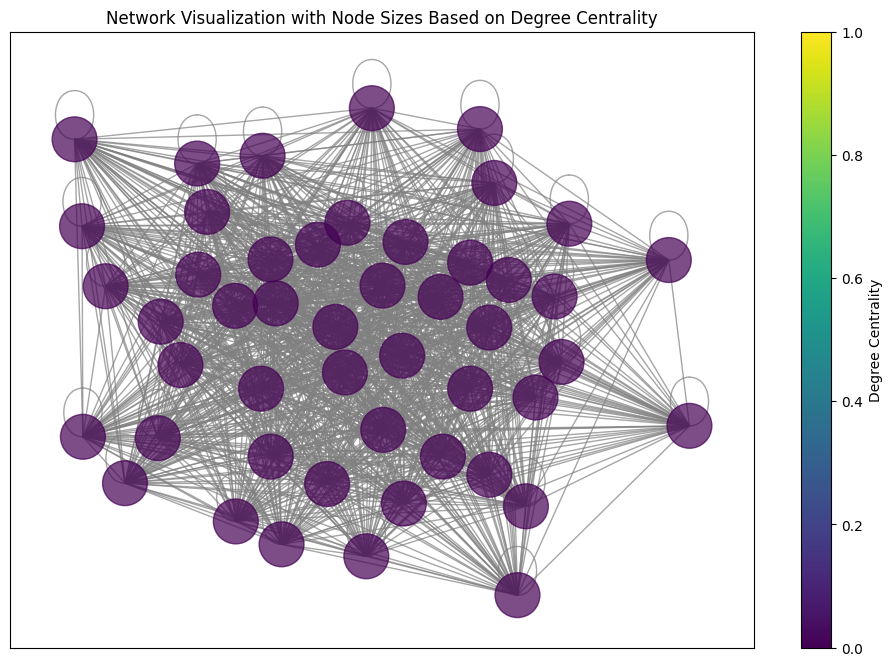

In [6]:
def graph_one(correlation_matrix):
    # Convert matrix to graph
    G = nx.from_numpy_array(correlation_matrix)

    # Compute graph metrics and combine into feature vector
    degree_centrality = nx.degree_centrality(G)
    clustering_coefficient = nx.clustering(G)
    features = list(degree_centrality.values()) + list(clustering_coefficient.values())
    centrality_values = list(degree_centrality.values())
    print(features)

    # Graph layout
    pos = nx.spring_layout(G, seed=42)

    # Normalize node colors based on centrality values
    node_sizes = [v * 1000 for v in centrality_values]
    node_colors = centrality_values

    # Draw network
    plt.figure(figsize=(12, 8))
    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=False,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        edge_color='gray',
        alpha=0.7
    )
    plt.title('Network Visualization with Node Sizes Based on Degree Centrality')
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), label='Degree Centrality')
    plt.show()

graph_one(correlation_matrix)

ASD

Time series shape: (196, 48)
Number of labels: 49


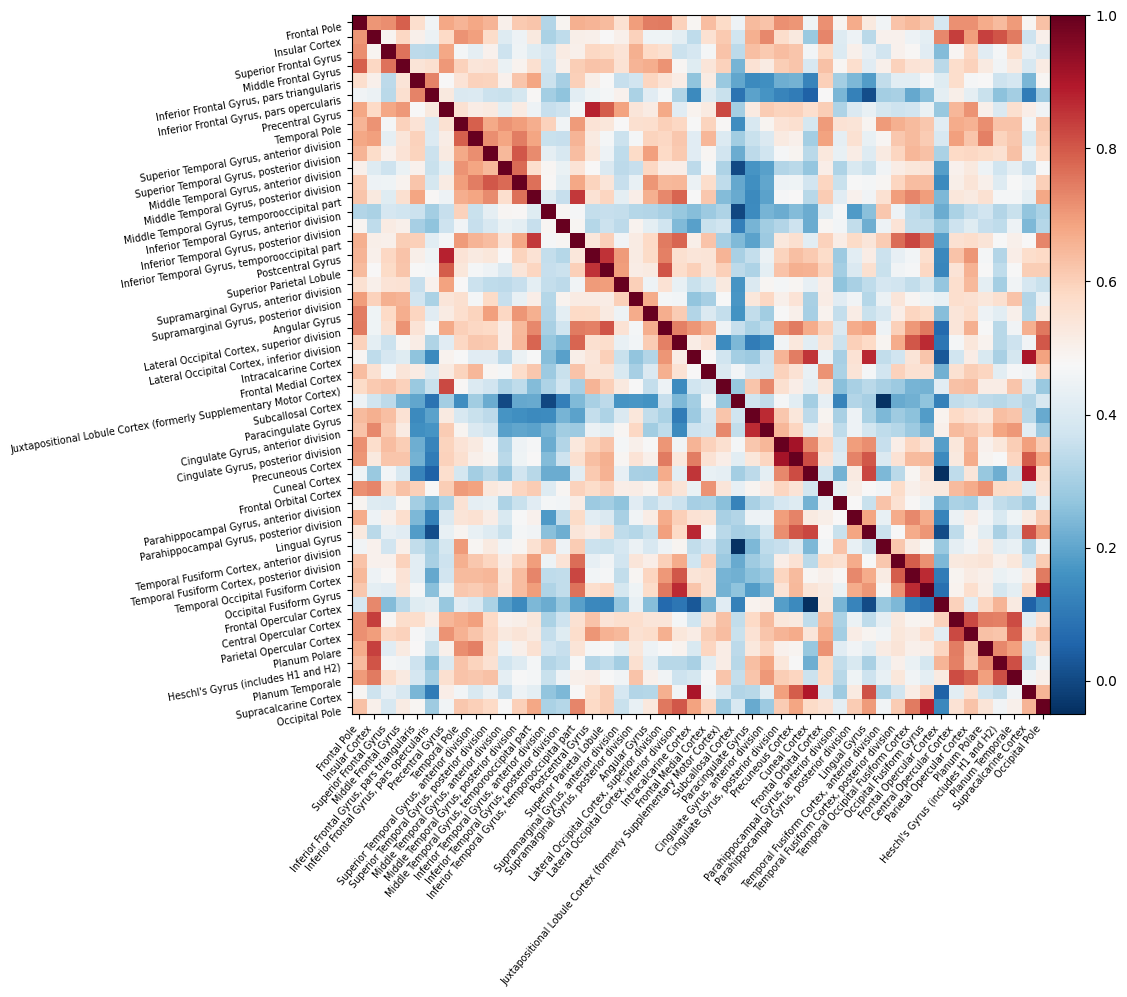

In [7]:
# Visualize correlation matrix
correlation_matrix = visualize_one(abide_asd)
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=valid_labels)

[1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0425531914893618, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

<ipython-input-6-278fbb38d507>:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), label='Degree Centrality')


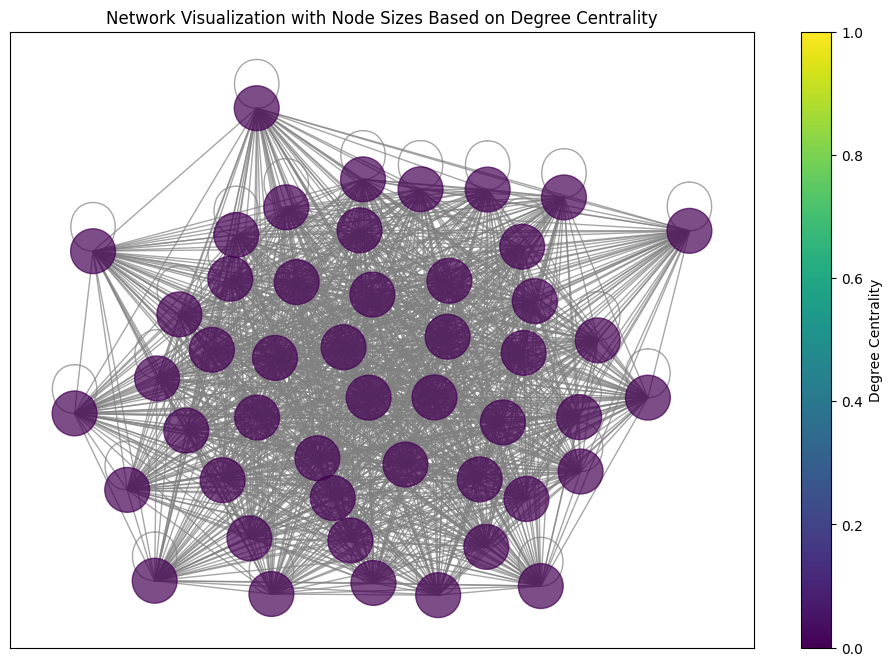

In [8]:
graph_one(correlation_matrix)

# Preprocessing, Flattening of Matrices into 1D for Classification, and Label conversion of 2 to 0

In [9]:
X = []  # Correlation matrices
X_flattened = []  # Flattened correlation matrices
y = []  # Labels

# Get names and confounds
fmri_filenames = abide_data['func_preproc']
confounds_filenames = abide_data['confounds'] if 'confounds' in abide_data else []


# Loop over all subjects
for i in tqdm(range(len(fmri_filenames))):
    fmri_filename = fmri_filenames[i]

    # Extract time series if confounds exist
    confounds_filename = confounds_filenames[i] if i < len(confounds_filenames) else None
    if confounds_filename is not None:
        time_series = masker.fit_transform(fmri_filename, confounds=confounds_filename)
    else:
        time_series = masker.fit_transform(fmri_filename)

    # Compute store, and flatten correlation matrix
    correlation_matrix = connectivity_measure.fit_transform([time_series])[0]
    X.append(correlation_matrix)
    X_flattened.append(correlation_matrix.flatten())

    # Append label
    subject_label = abide_data['phenotypic']['DX_GROUP'][i]
    y.append(subject_label)

# Convert to np arrays for ML
X = np.array(X)
X_flattened = np.array(X_flattened)
y = np.array(y)
# Convert labels, now 0 is Control and 1 is ASD
y = [0 if label == 2 else 1 for label in y]
y = np.array(y)

# Check
print(f"\nShape of feature matrix X: {X.shape}")
print(f"Shape of flattened feature matrix X: {X_flattened.shape}")
print(f"Shape of label vector y: {y.shape}")

100%|██████████| 400/400 [1:57:52<00:00, 17.68s/it]


Shape of feature matrix X: (400, 48, 48)
Shape of flattened feature matrix X: (400, 2304)
Shape of label vector y: (400,)


# Compute and Visualize Graph Measures

In [10]:
# Initialize a list to store data
data_list = []

# Loop over each subject
for i in range(len(X)):
    G = nx.from_numpy_array(X[i])
    # Remove isolated nodes
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)

    # Compute graph measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
    closeness_centrality = nx.closeness_centrality(G)
    clustering_coefficients = nx.clustering(G)

    if nx.is_connected(G):
        eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
    else:
        eigenvector_centrality = {node: 0 for node in G.nodes()}

    try:
        pagerank = nx.pagerank(G, max_iter=500, tol=1e-04)
    except nx.PowerIterationFailedConvergence:
        pagerank = {node: 0 for node in G.nodes()}


    # Aggregates
    measures = {
        'degree_centrality_mean': np.mean(list(degree_centrality.values())),
        'betweenness_centrality_mean': np.mean(list(betweenness_centrality.values())),
        'closeness_centrality_mean': np.mean(list(closeness_centrality.values())),
        'clustering_coefficient_mean': np.mean(list(clustering_coefficients.values())),
        'eigenvector_centrality_mean': np.mean(list(eigenvector_centrality.values())),
        'pagerank_mean': np.mean(list(pagerank.values()))
    }

    # Global measures
    measures['assortativity'] = nx.degree_assortativity_coefficient(G)
    measures['transitivity'] = nx.transitivity(G)
    measures['average_clustering'] = nx.average_clustering(G)

    # Possible disconnected graphs
    if nx.is_connected(G):
        measures['avg_shortest_path_length'] = nx.average_shortest_path_length(G)
    else:
        measures['avg_shortest_path_length'] = np.nan

    # Add label, append
    measures['Label'] = y[i]
    data_list.append(measures)

# Convert to df and separate
data_df = pd.DataFrame(data_list)
control_df = data_df[data_df['Label'] == 0]
asd_df = data_df[data_df['Label'] == 1]
control_df.head(10)

/usr/local/lib/python3.10/dist-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/networkx/algorithms/link_analysis/pagerank_alg.py:497: RuntimeWarning: invalid value encountered in subtract
  err = np.absolute(x - xlast).sum()


,degree_centrality_mean,betweenness_centrality_mean,closeness_centrality_mean,clustering_coefficient_mean,eigenvector_centrality_mean,pagerank_mean,assortativity,transitivity,average_clustering,avg_shortest_path_length,Label
200,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,0
201,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,0
202,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,0
203,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,0
204,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,0
205,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,0
206,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,0
207,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,0
208,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,0
209,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,0


In [26]:
asd_df.head(10)

,degree_centrality_mean,betweenness_centrality_mean,closeness_centrality_mean,clustering_coefficient_mean,eigenvector_centrality_mean,pagerank_mean,assortativity,transitivity,average_clustering,avg_shortest_path_length,Label
0,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,1
1,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,1
2,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,1
3,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,1
4,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,1
5,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,1
6,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,1
7,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,1
8,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,1
9,1.042553,0.0,1.0,1.0,0.144338,0.020833,NaN,1.0,1.0,1.0,1


# Find Meaningful differences

In [18]:
measure_names = data_df.columns.drop('Label')
test_results = []

for measure in measure_names:
    control_values = control_df[measure].dropna()
    asd_values = asd_df[measure].dropna()

    # T-test
    t_stat, p_value = ttest_ind(control_values, asd_values, equal_var=False)
    test_results.append({
        'Measure': measure,
        'Control_Mean': control_values.mean(),
        'ASD_Mean': asd_values.mean(),
        't_stat': t_stat,
        'p_value': p_value
    })

# Convert to df
test_results_df = pd.DataFrame(test_results)

# Apply Bonferroni correction
test_results_df['p_value_corrected'] = test_results_df['p_value'] * len(test_results_df)
test_results_df['Significant'] = test_results_df['p_value_corrected'] < 0.05
test_results_df.head(10)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,Measure,Control_Mean,ASD_Mean,t_stat,p_value,p_value_corrected,Significant
0,degree_centrality_mean,1.042137,1.041312,1.157381e+00,0.248113,2.481126,False
1,betweenness_centrality_mean,0.000000,0.000000,NaN,NaN,NaN,False
2,closeness_centrality_mean,0.999583,0.998759,1.157381e+00,0.248113,2.481126,False
3,clustering_coefficient_mean,0.999792,0.999375,1.161530e+00,0.246429,2.464294,False
4,eigenvector_centrality_mean,0.142894,0.141451,8.213259e-01,0.412005,4.120055,False
5,pagerank_mean,0.019687,0.019688,-7.286446e-15,1.000000,10.000000,False
6,assortativity,1.000000,1.000000,1.732051e+00,0.181690,1.816901,False
7,transitivity,1.000000,1.000000,NaN,NaN,NaN,False
8,average_clustering,0.999792,0.999375,1.161530e+00,0.246429,2.464294,False
9,avg_shortest_path_length,1.000000,1.000000,NaN,NaN,NaN,False


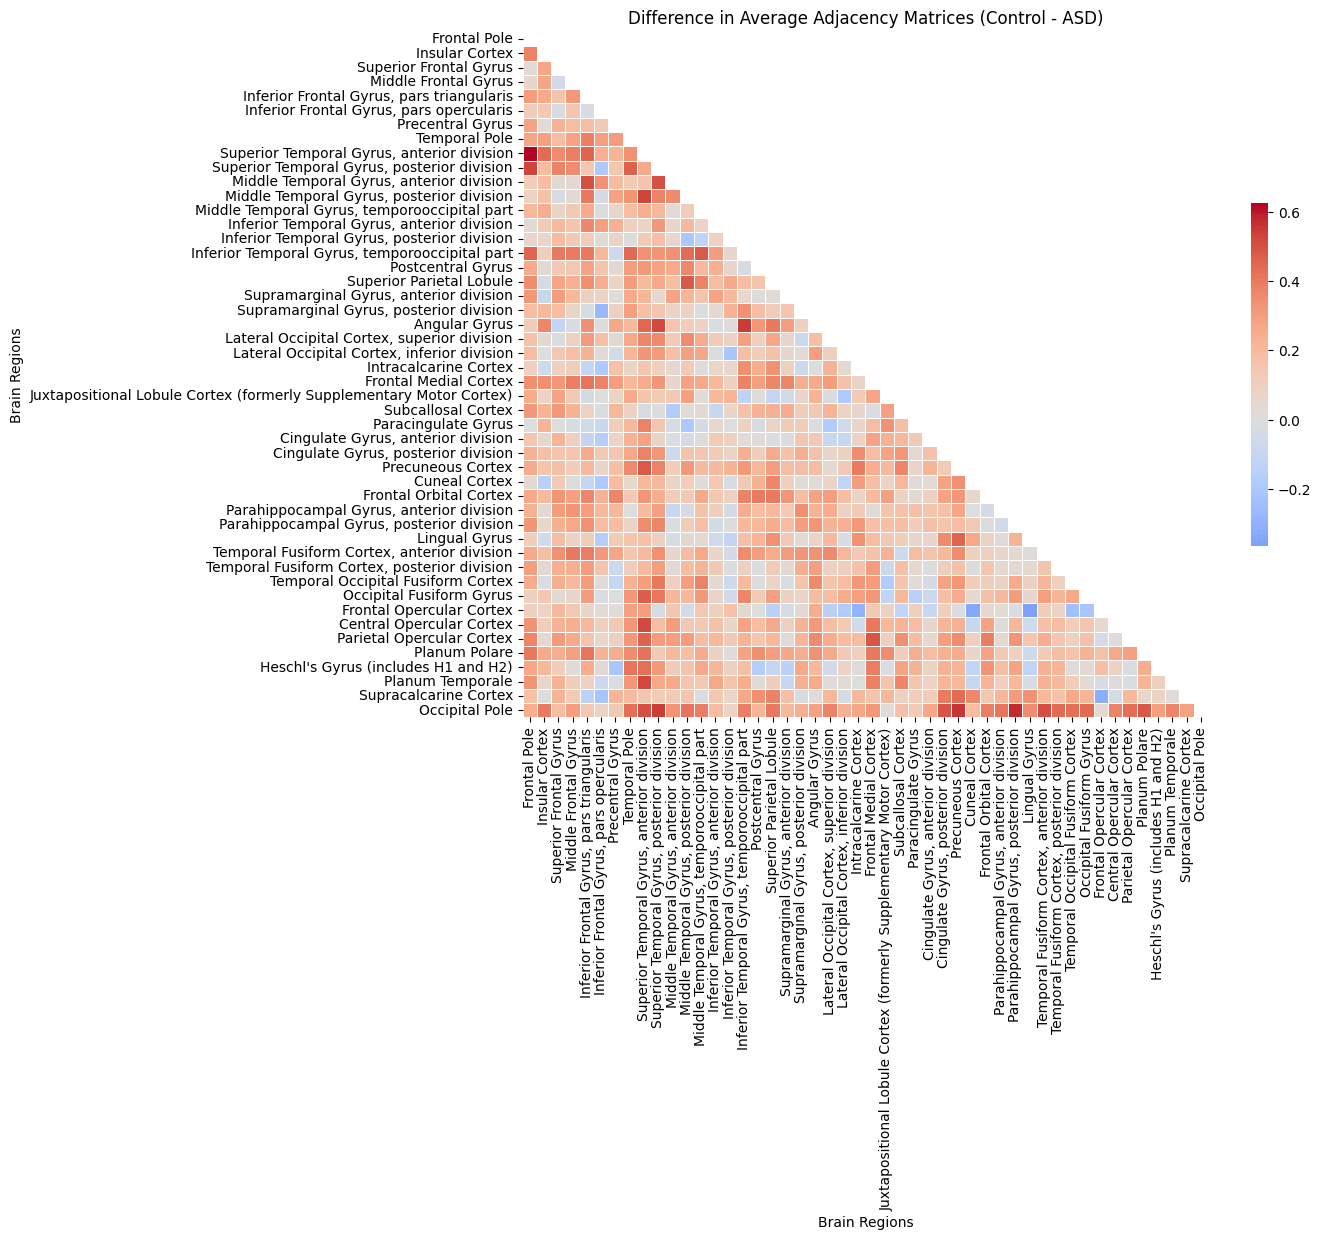

In [19]:
# Create mean matrices and the difference matrix
control_matrices = []
asd_matrices = []
for i in y:
    if i == 0:
        control_matrices.append(X[i])
    else:
        asd_matrices.append(X[i])
mean_control_adj = np.mean(control_matrices, axis=0)
mean_asd_adj = np.mean(asd_matrices, axis=0)
diff_adj = mean_control_adj - mean_asd_adj

# Assert label length = matrix shape
num_labels = len(valid_labels)
assert diff_adj.shape[0] == num_labels, "Mismatch between number of labels and matrix dimensions."

# Upper triangle mask
mask = np.triu(np.ones_like(diff_adj, dtype=bool))

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    diff_adj,
    mask=mask,
    cmap='coolwarm',
    vmax=np.max(diff_adj),
    vmin=np.min(diff_adj),
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5},
    xticklabels=valid_labels,
    yticklabels=valid_labels
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Difference in Average Adjacency Matrices (Control - ASD)')
plt.xlabel('Brain Regions')
plt.ylabel('Brain Regions')
plt.tight_layout()
plt.show()


# Feature Extraction and Logistic Regression

LR Accuracy:
Accuracy: 57.50%

Classification Report for LR:
              precision    recall  f1-score   support

           0       0.61      0.42      0.50        40
           1       0.56      0.72      0.63        40

    accuracy                           0.57        80
   macro avg       0.58      0.57      0.57        80
weighted avg       0.58      0.57      0.57        80



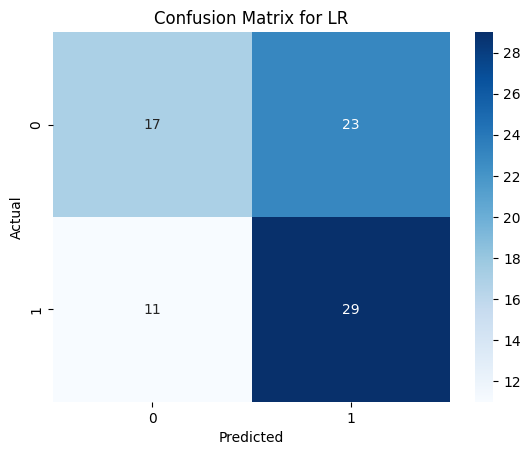


LR Cross-validation Metrics:
Cross-validation scores: [0.5625 0.5875 0.6375 0.7125 0.65  ]
Mean accuracy: 0.6300
Standard deviation: 0.0522


In [22]:
# Dimensionality Reduction (PCA)
pca = PCA(n_components=len(abide_data))
X_pca = pca.fit_transform(X_flattened)

# Train-test split and train
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# RESULTS
accuracy = accuracy_score(y_test, y_pred)
print("LR Accuracy:")
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report for LR:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for LR')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_flattened, y, cv=kf, scoring='accuracy')
print("\nLR Cross-validation Metrics:")
print(f'Cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean():.4f}')
print(f'Standard deviation: {scores.std():.4f}')

# Support Vector Machine (SVM)

SVM Accuracy:
Accuracy: 57.50%

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.53      0.50      0.51        36
           1       0.61      0.64      0.62        44

    accuracy                           0.57        80
   macro avg       0.57      0.57      0.57        80
weighted avg       0.57      0.57      0.57        80



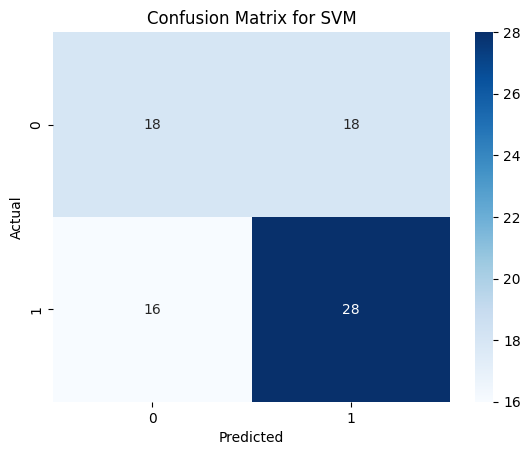


SVM Cross-validation Metrics:
Cross-validation scores: [0.575  0.6125 0.6375 0.7125 0.5875]
Mean accuracy: 0.6250
Standard deviation: 0.0487


In [24]:
if X_flattened.shape[0] > 1:
    # Train-test split, train and evaluate
    X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

else: # If only one sample
    svm = SVC(kernel='linear')
    svm.fit(X_flattened, y)
    print("Not enough samples for a meaningful train-test split. Model trained on the single sample.")

# RESULTS
accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:")
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report for SVM:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
scores = cross_val_score(svm, X_flattened, y, cv=kf, scoring='accuracy')
print("\nSVM Cross-validation Metrics:")
print(f'Cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean():.4f}')
print(f'Standard deviation: {scores.std():.4f}')

# Support Vector Machine (SVM) with Grid Search for Hyperparameter Tuning

Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}

SVM with grid search Accuracy:
Accuracy: 62.50%

Classification Report for SVM with grid search:
              precision    recall  f1-score   support

           0       0.57      0.64      0.61        36
           1       0.68      0.61      0.64        44

    accuracy                           0.62        80
   macro avg       0.62      0.63      0.62        80
weighted avg       0.63      0.62      0.63        80



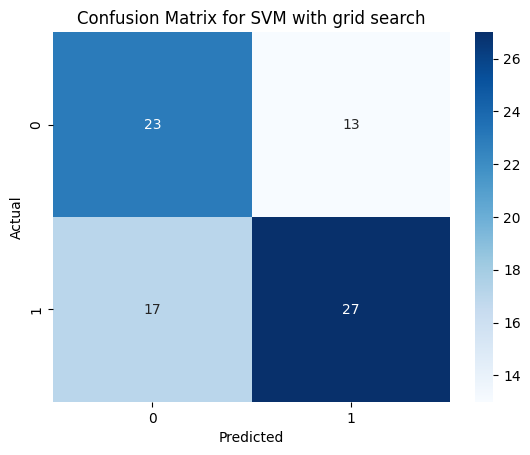


SVM with grid search Cross-validation Metrics:
Cross-validation scores: [0.6125 0.5875 0.6625 0.6875 0.575 ]
Mean accuracy: 0.6250
Standard deviation: 0.0433


In [25]:
# SVM and scaling pipeline
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('svm', SVC())  # SVM classifier
])

# Parameter grid for grid search
param_grid_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf']
}

# Train-test split, grid search, train and evaluate
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)
grid_svm = GridSearchCV(pipeline_svm, param_grid=param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)
y_pred_svm = grid_svm.predict(X_test)
print(f"Best parameters for SVM: {grid_svm.best_params_}\n")

# RESULTS
accuracy = accuracy_score(y_test, y_pred_svm)
print("SVM with grid search Accuracy:")
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report for SVM with grid search:")
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for SVM with grid search')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
scores = cross_val_score(grid_svm, X_flattened, y, cv=kf, scoring='accuracy')
print("\nSVM with grid search Cross-validation Metrics:")
print(f'Cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean():.4f}')
print(f'Standard deviation: {scores.std():.4f}')

# Random Forest Classifier

Best parameters for Random Forest: {'rf__max_depth': 30, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}

Random Forest Accuracy:
Accuracy: 58.75%

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.53      0.67      0.59        36
           1       0.66      0.52      0.58        44

    accuracy                           0.59        80
   macro avg       0.60      0.59      0.59        80
weighted avg       0.60      0.59      0.59        80



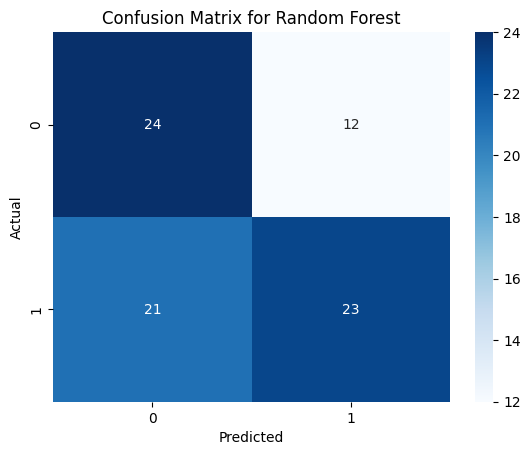


Random Forest Cross-validation Metrics:
Cross-validation scores: [0.5625 0.55   0.6375 0.6625 0.525 ]
Mean accuracy: 0.5875
Standard deviation: 0.0530


In [34]:
# Random Forest pipeline
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('rf', RandomForestClassifier(n_estimators=100))  # Random Forest classifier
])

# Parameter grid for grid search
param_grid_rf = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30],
    'rf__min_samples_split': [2, 5, 10]
}

# Train-test split, grid search, train and evaluate
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)
grid_rf = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, cv=5)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
print(f"Best parameters for Random Forest: {grid_rf.best_params_}\n")

# RESULTS
accuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:")
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
scores = cross_val_score(grid_rf, X_flattened, y, cv=kf, scoring='accuracy')
print("\nRandom Forest Cross-validation Metrics:")
print(f'Cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean():.4f}')
print(f'Standard deviation: {scores.std():.4f}')

# Gradient Boosting Classifier (XGBoost)

XGBoost Accuracy:
Accuracy: 60.00%

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.55      0.58      0.57        36
           1       0.64      0.61      0.63        44

    accuracy                           0.60        80
   macro avg       0.60      0.60      0.60        80
weighted avg       0.60      0.60      0.60        80



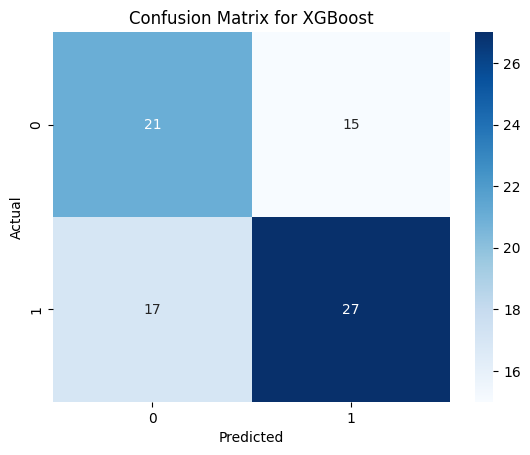


XGBoost Cross-validation Metrics:
Cross-validation scores: [0.6    0.5625 0.6375 0.525  0.5625]
Mean accuracy: 0.5775
Standard deviation: 0.0382


In [28]:
# XGBoost pipeline
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('xgb', XGBClassifier())  # XGBoost classifier
])

# Train-test split, train and evaluate
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)
pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)

# RESULTS
accuracy = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:")
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_xgb, X_flattened, y, cv=kf, scoring='accuracy')
print("\nXGBoost Cross-validation Metrics:")
print(f'Cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean():.4f}')
print(f'Standard deviation: {scores.std():.4f}')

# Graph Neural Network (GNN)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


Loss: 0.6260
GNN Accuracy:
Accuracy: 55.00%

Classification Report for GNN:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57        36
           1       0.62      0.45      0.53        44

    accuracy                           0.55        80
   macro avg       0.56      0.56      0.55        80
weighted avg       0.57      0.55      0.55        80



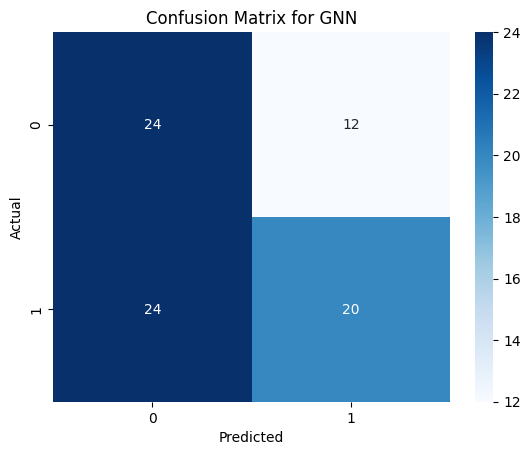

In [30]:
# Func to turn correlation matrix into graph
def correlation_to_graph(correlation_matrix, label, threshold=0.3):
    # Get number of brain regions, create identity matrix, edge index and attributes
    num_nodes = correlation_matrix.shape[0]
    node_features = np.eye(num_nodes)
    edge_index = np.argwhere(np.abs(correlation_matrix) > threshold).T
    edge_attr = correlation_matrix[edge_index[0], edge_index[1]]

    # Convert to PyTorch Geometric Data format
    data = Data(
        x=torch.tensor(node_features, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        edge_attr=torch.tensor(edge_attr, dtype=torch.float),
        y=torch.tensor([label], dtype=torch.long)
    )
    return data

# Graph Convolutional Network class
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels=48, out_channels=64)  # 48 ROIs from atlas
        self.conv2 = GCNConv(in_channels=64, out_channels=32)
        self.fc = torch.nn.Linear(32, 2)  # 2 because binary classification

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))  # First ReLU layer
        x = F.relu(self.conv2(x, edge_index))  # Second ReLU layer
        x = global_mean_pool(x, batch)  # Pooling layer
        x = self.fc(x)  # Fully connected layer
        return F.log_softmax(x, dim=1)

# Train function
def train_model(num_epochs, train_loader, model, optimizer):
    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)  # Forward pass
            loss = F.nll_loss(out, batch.y)  # Cross-entropy loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            total_loss += loss.item()

        # tqdm.write(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}')
    loss = total_loss / len(train_loader)
    print(f"Loss: {loss:.4f}")

# Evaluate function
def evaluate_model(model, test_loader):
    model.eval()  # Set model to eval mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradients during testing
        for batch in test_loader:
            batch = batch.to(device)  # Move batch to device
            outputs = model(batch)  # Forward pass
            preds = torch.argmax(outputs, dim=1)  # Get predicted class
            all_preds.extend(preds.cpu().numpy().flatten()) # Flatten
            all_labels.extend(batch.y.cpu().numpy().flatten()) # Flatten


    # RESULTS
    accuracy = accuracy_score(all_labels, all_preds)
    print("GNN Accuracy:")
    print(f"Accuracy: {accuracy * 100:.2f}%")

    print("\nClassification Report for GNN:")
    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for GNN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy

# Convert to graph
graph_data_list = []
for i in range(len(X)):
    graph_data = correlation_to_graph(X[i], y[i])
    graph_data_list.append(graph_data)

# Train-test split, create dataloader and train the model
train_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

# Cuda hardware accel if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Run and evaluate
train_model(num_epochs, train_loader, model, optimizer)
test_accuracy = evaluate_model(model, test_loader)

# Convolutional Neural Network (CNN)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


CNN Accuracy:
Loss: 0.4562
Accuracy: 55.00%

Classification Report for CNN:
              precision    recall  f1-score   support

           0       0.50      0.53      0.51        36
           1       0.60      0.57      0.58        44

    accuracy                           0.55        80
   macro avg       0.55      0.55      0.55        80
weighted avg       0.55      0.55      0.55        80



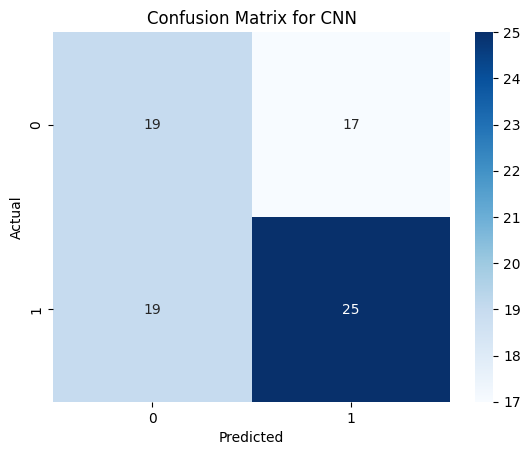

0.55

In [32]:
# CNN Class
class CNN(nn.Module):
    def __init__(self, num_channels=1, num_classes=2):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # Max pooling
        self.fc = nn.Linear(in_features=2304, out_features=num_classes) # Input size of the FC layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1) # Flatten tensor before passing to FC layer
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Train function
def train_model(num_epochs, train_loader, model, optimizer, criterion):
    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs, y_batch)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        # tqdm.write(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

# Evaluate function
def evaluate_model(val_loader, model, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(y_batch.cpu().numpy().flatten())

    # RESULTS
    loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    print("CNN Accuracy:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")

    print("\nClassification Report for CNN:")
    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for CNN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy

# Convert into tensors and prep dataset
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

model = CNN(num_channels=1, num_classes=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.NLLLoss()
num_epochs = 50

# Run and evaluate
train_model(num_epochs, train_loader, model, optimizer, criterion)
evaluate_model(test_loader, model, criterion)

# Transformer-based Model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
100%|██████████| 50/50 [02:06<00:00,  2.53s/it]


Transformer Accuracy:
Loss: 0.4212
Accuracy: 48.75%

Classification Report for Transformer:
              precision    recall  f1-score   support

           0       0.44      0.47      0.45        36
           1       0.54      0.50      0.52        44

    accuracy                           0.49        80
   macro avg       0.49      0.49      0.49        80
weighted avg       0.49      0.49      0.49        80



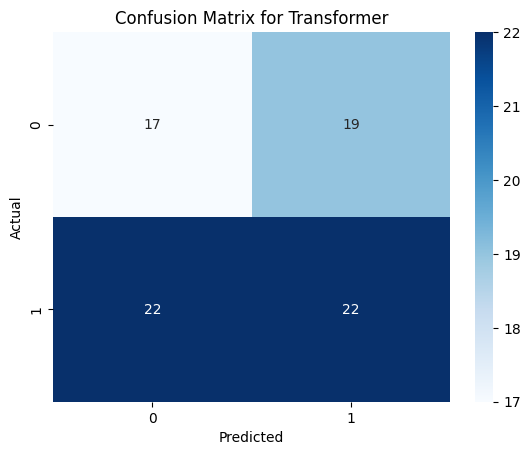

0.4875

In [33]:
class TransformerModel(nn.Module):
    def __init__(self, num_tokens=48, d_model=64, num_heads=4, num_classes=2, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Linear(num_tokens, d_model)

        # Transformer Encoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # FC layer
        self.fc = nn.Linear(d_model, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Remove the channel dimension
        x = x.squeeze(1)

        # Embedding
        x = self.embedding(x)

        # Permute for transformers expected dimension
        x = x.permute(1, 0, 2)

        # Transformer encoder
        x = self.transformer_encoder(x)

        # Mean pooling
        x = x.mean(dim=0)

        # Dropout
        x = self.dropout(x)

        # FC layer
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

# Evaluate function
def evaluate_model(val_loader, model, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(y_batch.cpu().numpy().flatten())

    # RESULTS
    loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    print("Transformer Accuracy:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")

    print("\nClassification Report for Transformer:")
    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for Transformer')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy

model_2 = TransformerModel(num_tokens=48, d_model=64, num_heads=4, num_classes=2, num_layers=2)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.001)

num_epochs = 50
train_model(num_epochs, train_loader, model_2, optimizer_2, criterion)
evaluate_model(test_loader, model_2, criterion)